# Ultimate Data Science Challenge

In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

plt.style.use('ggplot')
%matplotlib inline

## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [451]:
logins = pd.read_json('logins.json')

In [452]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [453]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


No null values present and the dataset looks like it was read cleanly.

In [454]:
# Turn the datetimes into the index and create a count which is them summed during resampling
logins = logins.set_index('login_time')
logins['count'] = 1
logins = logins.resample('15T').sum()
logins.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [455]:
logins.tail()

,count
login_time,
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


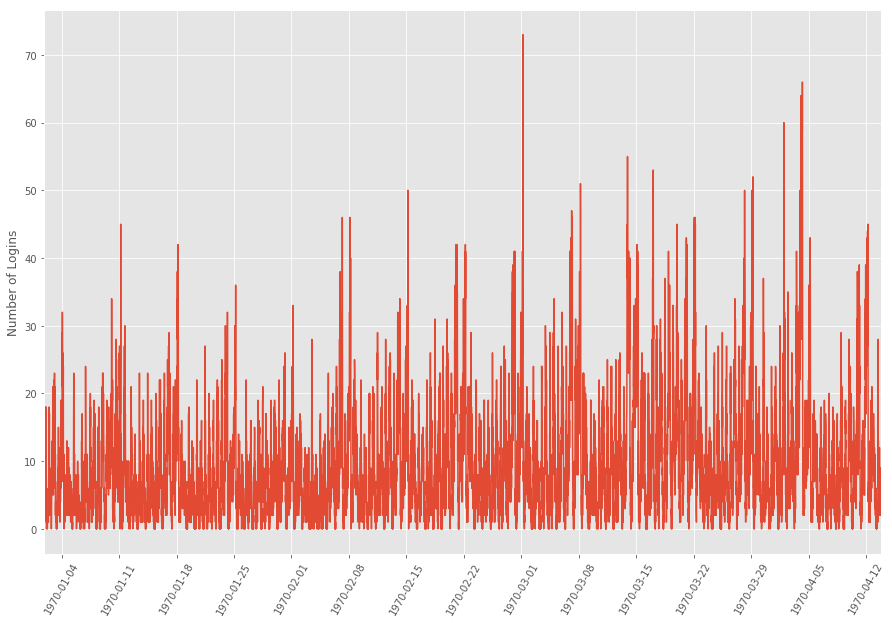

In [456]:
tick_spacing = 7

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(logins)
plt.xticks(rotation=60)
plt.ylabel('Number of Logins')
plt.xlim([logins.index[0], logins.index[-1]])
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

The figure is a little cluttered, but we can see some trends popping up. There looks to be a repeated pattern. It'll be easier to look at trends if we shorten the timescale. Let's start by breaking down incrementally by time cycle: Months, weeks, and days.

In [457]:
# Reset the index to use datetime objects
logins = logins.reset_index()

In [458]:
# Applying a day of the week column (0=Monday, 6=Sunday)
logins['weekday'] = logins.login_time.apply(lambda x: x.weekday())

In [459]:
# Applying month column (1 for Jan, etc.)
logins['month'] = logins.login_time.apply(lambda x: x.month)

In [460]:
# Setting index to datetime
logins = logins.set_index('login_time')

In [461]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Data columns (total 3 columns):
count      9788 non-null int64
weekday    9788 non-null int64
month      9788 non-null int64
dtypes: int64(3)
memory usage: 305.9 KB


In [462]:
# Creating a dictionary to use with the .replace() function
cleanup_dict = {'weekday': {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                            4: 'Friday', 5:'Saturday', 6: 'Sunday'},
                'month': {1: 'January', 2: 'February', 3: 'March', 4: 'April'}}

In [463]:
# Replacing the ints with the real names
logins.replace(cleanup_dict, inplace=True)

In [464]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Data columns (total 3 columns):
count      9788 non-null int64
weekday    9788 non-null object
month      9788 non-null object
dtypes: int64(1), object(2)
memory usage: 305.9+ KB


In [465]:
# Turning the variables into categorical
logins.weekday = logins.weekday.astype('category')

In [466]:
logins.month = logins.month.astype('category')

In [467]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Data columns (total 3 columns):
count      9788 non-null int64
weekday    9788 non-null category
month      9788 non-null category
dtypes: category(2), int64(1)
memory usage: 172.6 KB


In [468]:
logins.head()

,count,weekday,month
login_time,,,
1970-01-01 20:00:00,2,Thursday,January
1970-01-01 20:15:00,6,Thursday,January
1970-01-01 20:30:00,9,Thursday,January
1970-01-01 20:45:00,7,Thursday,January
1970-01-01 21:00:00,1,Thursday,January


In [469]:
# Subsetting the data by month
jan_df = logins.drop('weekday', axis=1).loc[logins.month=='January'].drop('month', axis=1)
feb_df = logins.drop('weekday', axis=1).loc[logins.month=='February'].drop('month', axis=1)
mar_df = logins.drop('weekday', axis=1).loc[logins.month=='March'].drop('month', axis=1)
apr_df = logins.drop('weekday', axis=1).loc[logins.month=='April'].drop('month', axis=1)

# Subsetting March to look at a single month
mar_1 = mar_df['03-01-1970' : '03-07-1970']
mar_2 = mar_df['03-08-1970' : '03-14-1970']
mar_3 = mar_df['03-15-1970' : '03-21-1970']
mar_4 = mar_df['03-22-1970' : '03-29-1970']

# Subsetting a week in March to look at a single week
sun = mar_2['03-08-1970']
mon = mar_2['03-09-1970']
tue = mar_2['03-10-1970']
wed = mar_2['03-11-1970']
thu = mar_2['03-12-1970']
fri = mar_2['03-13-1970']
sat = mar_2['03-14-1970']

months = [jan_df, feb_df, mar_df, apr_df]
mar_weeks = [mar_1, mar_2, mar_3, mar_4]
days = [sun, mon, tue, wed, thu, fri, sat, sun]

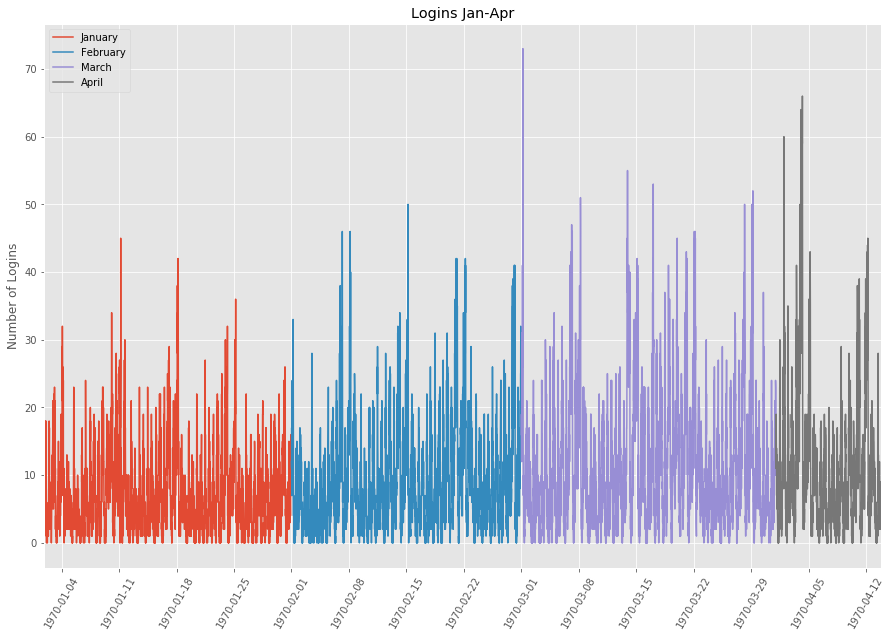

In [470]:
# Plotting the monthly trends
tick_spacing = 7
month_labels=['January', 'February', 'March', 'April']

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for df in months:
    ax.plot(df)
plt.xticks(rotation=60)
plt.ylabel('Number of Logins')
plt.legend(month_labels, loc='upper left')
plt.title('Logins Jan-Apr')
plt.xlim([logins.index[0], logins.index[-1]])
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

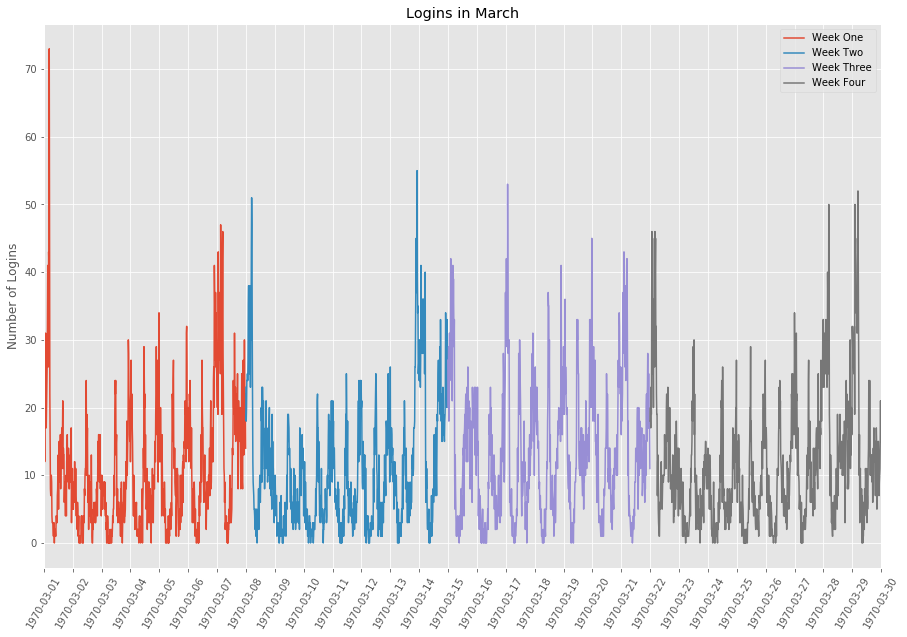

In [471]:
tick_spacing = 1
week_labels=['Week One', 'Week Two', 'Week Three', 'Week Four']

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for df in mar_weeks:
    ax.plot(df)
plt.xticks(rotation=60)
plt.ylabel('Number of Logins')
plt.title('Logins in March')
plt.legend(week_labels, loc='upper right')
plt.xlim([mar_1.index[0], mar_4.index[-1]])
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

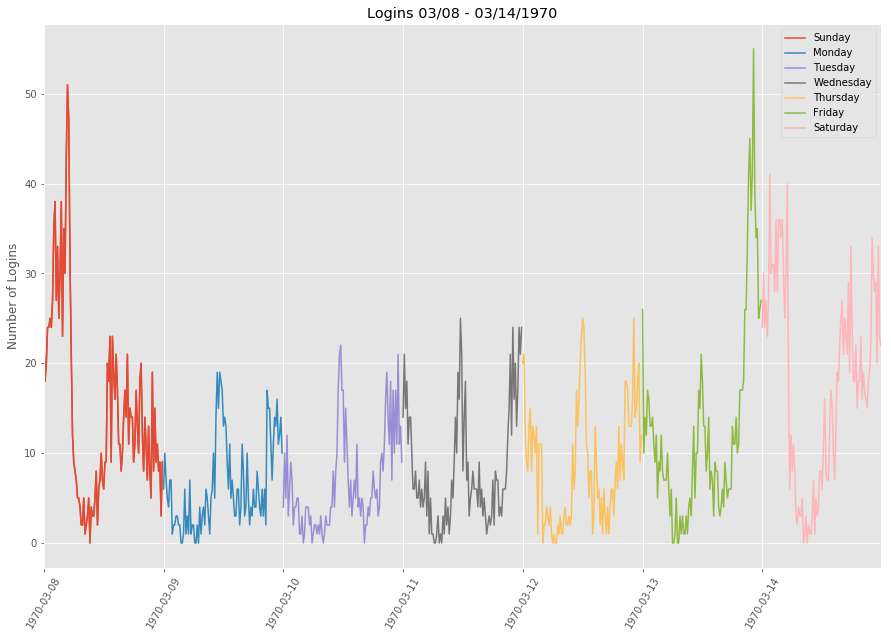

In [552]:
tick_spacing = 1
day_labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for df in days:
    ax.plot(df)
plt.xticks(rotation=60)
plt.ylabel('Number of Logins')
plt.title('Logins 03/08 - 03/14/1970')
plt.legend(day_labels, loc='upper right')
plt.xlim([mar_2.index[0], mar_2.index[-1]])
ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

### Findings

There is a general trend towards the positive as the months progress out of winter. When zooming in on one month, we can see the main trend which fluctuates by day of the week and by hour. The number of logins increases as the weekend approaches and maxes out over the weekend. There are distinct peaks in total logins each day during the morning, lunchtime, and evening hours.

## Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


### Answer

1. With the key measure of success being drivers serving both cities, the metric by which to measure it would be amount of time spent in each city calculated as a percentage. Due to the toll bridge, it's likely that Gotham drivers spend the largest percentage of their time in Gotham and Metropolis drivers the opposite. So, identifying a significant change in the percentage of time in each city would be the best metric.

2. I would set up the experiment in the following way:
    1. This is operating under the assumption that null hypothesis location data has already been collected.
    2. Provide the toll reimbursement during random periods of time to account for confounding variables such as weather and seasonal changes.
    3. Separate the data into Gotham drivers and Metropolis drivers and perform one-tailed Z-tests. The Z-test is applicable as the sample size could easily be sufficient for the central limit theorem to apply (n > 30), and it can be one-tailed as we have a reasonable assumption that the alternate hypothesis will shift one direction. The hypotheses are as follows:
        1. $H_{0}$: There is no difference in mean percentage of time spent in Gotham/Metropolis.
        2. $H_{A}$: There is a difference in mean percentage of time spent in Gotham/Metropolis.
       
As stated previously, the key metric for success would be a significant difference in percentage of time in each city, but there are other factors that would need to be taken into account. Revenue for the company would also likely change. Its possible that the increased area available to drivers would offset the cost of the toll reimbursement, but its also possible it wouldn't. Perhaps a deal could be struck with the cities regarding tolls if the increased service is a boon. Also, its possible that over time the increased covereage would lead to an influx of drivers thereby increasing overall revenue enough that the toll reimbursement becomes more viable.

## Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

### Data description

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday

In [71]:
# Pandas .read_json() function was throwing a value error so I did it the alternate way
file = open('ultimate_data_challenge.json', 'r')
riders = pd.DataFrame(json.load(file))
file.close()

riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [72]:
# Examining the features and looking for null values
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [73]:
# There are some null values that will need to be addressed, but first let's change the dates to datetimes
riders.last_trip_date = pd.to_datetime(riders.last_trip_date)
riders.signup_date = pd.to_datetime(riders.signup_date)

Text(0.5, 1.0, 'Histogram of avg_rating_by_driver')

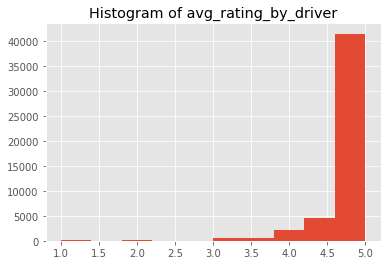

In [75]:
# Let's look at the features with missing values
plt.hist(riders.avg_rating_by_driver)
plt.title('Histogram of avg_rating_by_driver')

Text(0.5, 1.0, 'Histogram of avg_rating_by_driver')

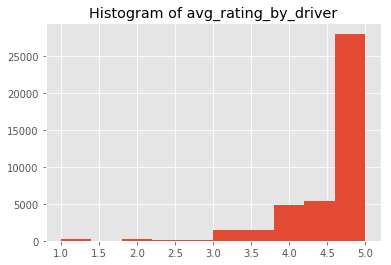

In [76]:
plt.hist(riders.avg_rating_of_driver)
plt.title('Histogram of avg_rating_by_driver')

In [77]:
riders.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

The two numerical features with missing values can be filled with the mean of the feature. As for `phone`, the distribution heavily favors iPhone, and since there are only 396 missing values, it's safe to fill them in with 'iPhone'.

In [78]:
riders.avg_rating_of_driver.fillna(riders.avg_rating_of_driver.mean(), inplace=True)
riders.avg_rating_by_driver.fillna(riders.avg_rating_by_driver.mean(), inplace=True)
riders.phone.fillna('iPhone', inplace=True)

In [79]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


We now have a complete dataset and can check for errors in the other features.

In [80]:
# Do the categorical variables contain typos?
riders.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [81]:
riders.phone.unique()

array(['iPhone', 'Android'], dtype=object)

No anomalies there. Now we should look for outliers in the numerical features.

In [82]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Text(0.5, 1.0, 'Boxplot of avg_dist')

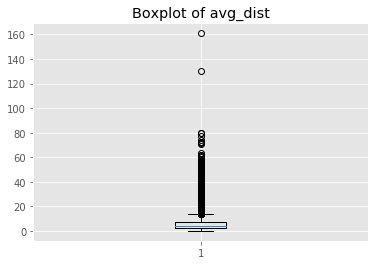

In [83]:
# avg_dist
plt.boxplot(riders.avg_dist)
plt.title('Boxplot of avg_dist')

Text(0.5, 1.0, 'Boxplot of avg_surge')

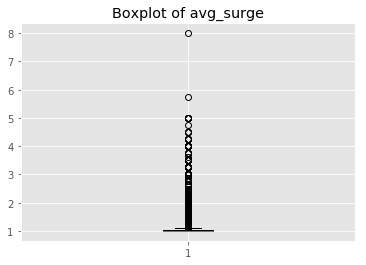

In [84]:
# avg_surge
plt.boxplot(riders.avg_surge)
plt.title('Boxplot of avg_surge')

Text(0.5, 1.0, 'Boxplot of avg_rating_by_driver')

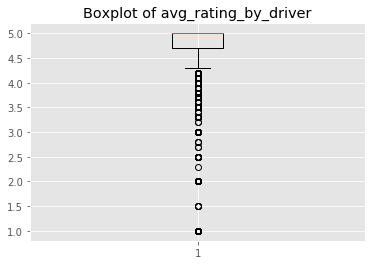

In [85]:
# avg_rating_by_driver
plt.boxplot(riders.avg_rating_by_driver)
plt.title('Boxplot of avg_rating_by_driver')

Text(0.5, 1.0, 'Boxplot of avg_rating_of_driver')

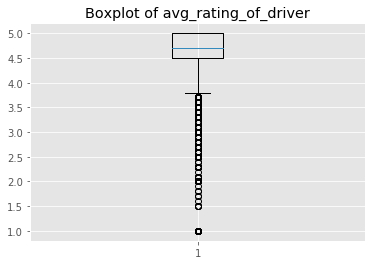

In [86]:
# avg_rating_of_driver
plt.boxplot(riders.avg_rating_of_driver)
plt.title('Boxplot of avg_rating_of_driver')

Text(0.5, 1.0, 'Boxplot of surge_pct')

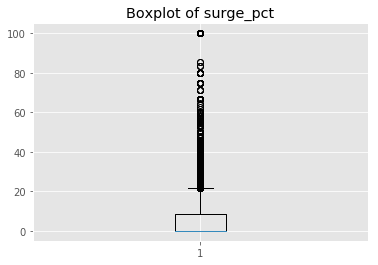

In [87]:
# surge_pct
plt.boxplot(riders.surge_pct)
plt.title('Boxplot of surge_pct')

Text(0.5, 1.0, 'Boxplot of trips_in_first_30_days')

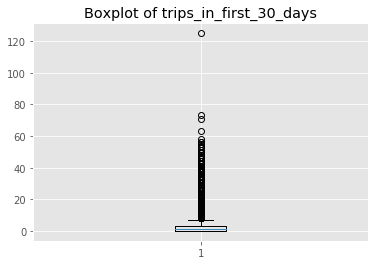

In [88]:
# trips_in_the_first_30_days
plt.boxplot(riders.trips_in_first_30_days)
plt.title('Boxplot of trips_in_first_30_days')

Text(0.5, 1.0, 'Boxplot of weekday_pct')

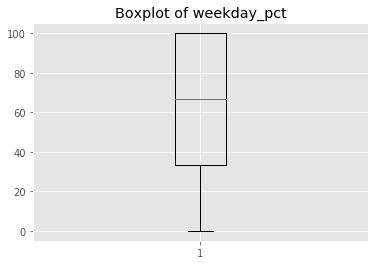

In [89]:
# weekday_pct
plt.boxplot(riders.weekday_pct)
plt.title('Boxplot of weekday_pct')

In looking at all the boxplots, there do seem to be distinct outliers in all of the features except for the last, `weekday_pct`. To handle these, we will filter out those that are above 3 standard deviations from the mean. We have enough data that removal will likely cause less of an issue than leaving them in, but after removal the number removed will be double checked.

In [90]:
riders = riders[np.abs(riders.avg_dist-riders.avg_dist.mean())<=(3*riders.avg_dist.std())]
riders = riders[np.abs(riders.avg_rating_by_driver-riders.avg_rating_by_driver.mean())<=(3*riders.avg_rating_by_driver.std())]
riders = riders[np.abs(riders.avg_rating_of_driver-riders.avg_rating_of_driver.mean())<=(3*riders.avg_rating_of_driver.std())]
riders = riders[np.abs(riders.avg_surge-riders.avg_surge.mean())<=(3*riders.avg_surge.std())]
riders = riders[np.abs(riders.surge_pct-riders.surge_pct.mean())<=(3*riders.surge_pct.std())]
riders = riders[np.abs(riders.trips_in_first_30_days-riders.trips_in_first_30_days.mean())<=(3*riders.trips_in_first_30_days.std())]
riders = riders.reset_index(drop=True)

In [91]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 12 columns):
avg_dist                  44666 non-null float64
avg_rating_by_driver      44666 non-null float64
avg_rating_of_driver      44666 non-null float64
avg_surge                 44666 non-null float64
city                      44666 non-null object
last_trip_date            44666 non-null datetime64[ns]
phone                     44666 non-null object
signup_date               44666 non-null datetime64[ns]
surge_pct                 44666 non-null float64
trips_in_first_30_days    44666 non-null int64
ultimate_black_user       44666 non-null bool
weekday_pct               44666 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.8+ MB


In [92]:
44666/50000

0.89332

We've only lost about 10% of the dataset by removing the outliers. This is acceptable due to the size of the dataset. Now we can move on to determine what riders were 'retained' as defined by active in the past 30 days.

In [93]:
riders.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [94]:
riders.last_trip_date.min()

Timestamp('2014-01-01 00:00:00')

The dataset ranges from January 1st to July 1st. The prompt asks us to predict active users in their 6th month. First let's check that all riders have a signup date in January.

In [95]:
riders.signup_date.unique()

array(['2014-01-25T00:00:00.000000000', '2014-01-29T00:00:00.000000000',
       '2014-01-06T00:00:00.000000000', '2014-01-10T00:00:00.000000000',
       '2014-01-27T00:00:00.000000000', '2014-01-09T00:00:00.000000000',
       '2014-01-24T00:00:00.000000000', '2014-01-28T00:00:00.000000000',
       '2014-01-21T00:00:00.000000000', '2014-01-03T00:00:00.000000000',
       '2014-01-13T00:00:00.000000000', '2014-01-15T00:00:00.000000000',
       '2014-01-12T00:00:00.000000000', '2014-01-02T00:00:00.000000000',
       '2014-01-19T00:00:00.000000000', '2014-01-16T00:00:00.000000000',
       '2014-01-26T00:00:00.000000000', '2014-01-17T00:00:00.000000000',
       '2014-01-31T00:00:00.000000000', '2014-01-22T00:00:00.000000000',
       '2014-01-20T00:00:00.000000000', '2014-01-04T00:00:00.000000000',
       '2014-01-05T00:00:00.000000000', '2014-01-30T00:00:00.000000000',
       '2014-01-11T00:00:00.000000000', '2014-01-07T00:00:00.000000000',
       '2014-01-18T00:00:00.000000000', '2014-01-01

All the riders have a signup date in January, so June will be the 6th month for all riders. 'Retained' riders will be defined as any rider who used the service in the month of June.

In [96]:
# Setting the binary response variable: 1 = retained, 0 = unretained
riders['retained'] = np.nan

riders.loc[riders.last_trip_date >= '2014-06-01', 'retained'] = 1
riders.loc[riders.last_trip_date < '2014-06-01', 'retained'] = 0

In [97]:
# Examining to see everything worked correctly
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0


In [98]:
# The response variable seems to be a float, let's check.
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 13 columns):
avg_dist                  44666 non-null float64
avg_rating_by_driver      44666 non-null float64
avg_rating_of_driver      44666 non-null float64
avg_surge                 44666 non-null float64
city                      44666 non-null object
last_trip_date            44666 non-null datetime64[ns]
phone                     44666 non-null object
signup_date               44666 non-null datetime64[ns]
surge_pct                 44666 non-null float64
trips_in_first_30_days    44666 non-null int64
ultimate_black_user       44666 non-null bool
weekday_pct               44666 non-null float64
retained                  44666 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 4.1+ MB


In [99]:
# Changing the response variable to an int
riders.retained = riders.retained.astype(int)

In [100]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 13 columns):
avg_dist                  44666 non-null float64
avg_rating_by_driver      44666 non-null float64
avg_rating_of_driver      44666 non-null float64
avg_surge                 44666 non-null float64
city                      44666 non-null object
last_trip_date            44666 non-null datetime64[ns]
phone                     44666 non-null object
signup_date               44666 non-null datetime64[ns]
surge_pct                 44666 non-null float64
trips_in_first_30_days    44666 non-null int64
ultimate_black_user       44666 non-null bool
weekday_pct               44666 non-null float64
retained                  44666 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.1+ MB


In [101]:
# last_trip_date is used to define the response variable and is therefore dropped.
riders = riders.drop('last_trip_date', axis=1)

In [102]:
# The signup_date is also dropped as it doesn't work with many models
riders = riders.drop('signup_date', axis = 1)

Now the data is ready to do a train/test split and try out some models after creating dummy variables for the categorical features.

In [103]:
# The booleans can simply be multiplied by 1
riders.ultimate_black_user = riders.ultimate_black_user * 1

In [104]:
# Creating dummy variables
riders = pd.get_dummies(riders, columns=['city', 'phone'])

In [105]:
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,1,0,1,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,1,0,1,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0,0,0,1,1,0


In [106]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 14 columns):
avg_dist                  44666 non-null float64
avg_rating_by_driver      44666 non-null float64
avg_rating_of_driver      44666 non-null float64
avg_surge                 44666 non-null float64
surge_pct                 44666 non-null float64
trips_in_first_30_days    44666 non-null int64
ultimate_black_user       44666 non-null int64
weekday_pct               44666 non-null float64
retained                  44666 non-null int64
city_Astapor              44666 non-null uint8
city_King's Landing       44666 non-null uint8
city_Winterfell           44666 non-null uint8
phone_Android             44666 non-null uint8
phone_iPhone              44666 non-null uint8
dtypes: float64(6), int64(3), uint8(5)
memory usage: 3.3 MB


In [107]:
# Checking the balance of the response variable
riders.retained.mean()

0.38586396811892715

The response variable is fairly balanced.

In [40]:
X = riders.drop('retained', axis=1)
y = riders.retained

In [41]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.30)

With the dataset cleaned and split between the train and test set, we can move on to testing different models for accuracy. As this is a classification problem, we'll look at a few different classifiers and logistic regression: `DecisionTreeClassifier`, `LogisticRegression`, `KNeighborsClassifier`, and `RandomForestClassifier`.

#### DecisionTreeClassifier

In [43]:
dt = DecisionTreeClassifier(random_state=23)

%time dt.fit(X_train, y_train)

pred = dt.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))

CPU times: user 133 ms, sys: 4.73 ms, total: 137 ms
Wall time: 138 ms
0.697910447761194
[[6166 2054]
 [1994 3186]]


#### LogisticRegression

In [45]:
lr = LogisticRegression(solver='liblinear')

%time lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))

CPU times: user 230 ms, sys: 5.48 ms, total: 236 ms
Wall time: 238 ms
0.716044776119403
[[6890 1330]
 [2475 2705]]


#### KNeighborsClassifier

In [58]:
knn = KNeighborsClassifier()

%time knn.fit(X_train, y_train)

pred = knn.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))

CPU times: user 305 ms, sys: 6.07 ms, total: 311 ms
Wall time: 313 ms
0.7387313432835821
[[6582 1638]
 [1863 3317]]


#### RandomForestClassifier

In [47]:
rfc = RandomForestClassifier(random_state=23, n_estimators=10)

%time rfc.fit(X_train, y_train)

pred = rfc.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))

CPU times: user 307 ms, sys: 12.1 ms, total: 319 ms
Wall time: 326 ms
0.7404477611940299
[[6739 1481]
 [1997 3183]]


As the random forest had the highest out-of-the-box accuracy, we can move forward to tunings the parameters. Given the size of the dataset, we'll use `RandomizedSearchCV` to narrow down the possibilities before moving onto the more thorough `GridSearchCV`.

In [61]:
# Builing the parameter grid and searching over the dataset
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}


rf = RandomForestClassifier()
rf_rs = RandomizedSearchCV(rf, param_grid, scoring='accuracy', random_state=23, n_iter=100, cv=3, n_jobs=-1)
%time rf_rs.fit(X_train, y_train)

CPU times: user 25.6 s, sys: 2.02 s, total: 27.6 s
Wall time: 1h 11min 14s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=23, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [62]:
# Best parameters from RandomizedSearchCV
rf_rs.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [65]:
# Building the smaller parameter grid for GridSearchCV
n_estimators = [980, 990, 1000, 1010, 1020]
min_samples_split = [10, 11, 12, 13]
min_samples_leaf = [1, 2, 3]
max_depth = [5, 6, 7, 8, 9, 10]
param_grid = {'n_estimators': n_estimators,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth}

rf = RandomForestClassifier(max_features='sqrt', bootstrap=True)
rf_gs = GridSearchCV(rf, param_grid, scoring='accuracy', cv=3)
%time rf_gs.fit(X_train, y_train)

CPU times: user 3h 29min 15s, sys: 1min 38s, total: 3h 30min 53s
Wall time: 3h 33min 9s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [980, 990, 1000, 1010, 1020], 'min_samples_split': [10, 11, 12, 13], 'min_samples_leaf': [1, 2, 3], 'max_depth': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [66]:
# Best parameters from the GridSearchCV
rf_gs.best_params_

{'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 13,
 'n_estimators': 980}

In [68]:
# Fitting and testing the model with tuned parameters
best_rf = RandomForestClassifier(max_features='sqrt', bootstrap=True, max_depth=10, min_samples_leaf=3,
                                 min_samples_split=13, n_estimators=980)
%time best_rf.fit(X_train, y_train)

best_pred = best_rf.predict(X_test)
print(accuracy_score(best_pred, y_test))
print(confusion_matrix(y_test, best_pred))

CPU times: user 15.4 s, sys: 176 ms, total: 15.5 s
Wall time: 15.6 s
0.7851492537313433
[[7039 1181]
 [1698 3482]]


In [118]:
# Let's look at the confusion matrix in a more readble way

def con_mat(model, X_train, X_test, y_train, y_test, y_pred):

    # This function takes train/test and prediction data to produce a
    # graphed confusion matrix and classification report
    
    cm = confusion_matrix(y_test, y_pred)
    labels=['Not Retained', 'Retained']
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of Retained Users')
    ttl = ax.title
    ttl.set_position([.5, 1.1])
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w", fontsize=24)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_test, y_pred))

[[7039 1181]
 [1698 3482]]


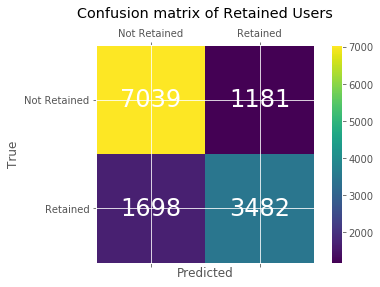

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      8220
           1       0.75      0.67      0.71      5180

   micro avg       0.79      0.79      0.79     13400
   macro avg       0.78      0.76      0.77     13400
weighted avg       0.78      0.79      0.78     13400



In [119]:
con_mat(best_rf, X_train, X_test, y_train, y_test, best_pred)

In [114]:
# Creating a dataframe of feature importances
feature_import = pd.DataFrame(best_rf.feature_importances_).transpose()
feature_import.columns = list(X.columns)
feature_import = feature_import.transpose()
feature_import.columns = ['RFC Feature Importance']
feature_import.sort_values(by='RFC Feature Importance', ascending=False)

,RFC Feature Importance
avg_rating_by_driver,0.173686
surge_pct,0.135836
weekday_pct,0.124461
city_King's Landing,0.116261
avg_surge,0.098929
avg_dist,0.059666
trips_in_first_30_days,0.058357
ultimate_black_user,0.057837
phone_Android,0.045381
phone_iPhone,0.045012


### Conclusion

We've fit a `RandomForestClassifier` and tuned it to achieve 78.5% accuracy. Precision, recall, and F1 were similar to accuracy: 79%, 78%, and 79% respectively. The lowest score on an individual class was recall with only a 67% on the positive class ('retained'). Since correctly identifying retained riders is the goal, this lower number should be noted. While a few models were tested, a random forest was predicted to be most effective as a random forest is an ensemble of decision trees which can themselves reach high accuracy but are susceptible to noise. Random forest can clear some of that noise.

Looking at the feature importances, we can see that `avg_rating_by_driver`, `surge_pct`, and `weekday_pct` top the list, but they are not noticeable stronger than the predictors that follow. This leads me to believe that the model is valid to an extent and could be strengthened with further data collection. My suspicion is that further use data throughout the preceeding months would be stronger predictors of retention than the data provided. As of now, the dataset has `last_trip_date`, `surge_pct`, and `weekday_pct` to determine use, but these alone are not fully capturing the totality of a rider's use of the service. I believe it likely that collection and analysis of more comprehensive use data would be effective at imporving the model, in particular the recall of the positive class which is the goal.

As for the data we have, we can look at the top three important features to see if there are some actionable insights.

In [122]:
retained = riders.loc[riders.retained == 1]
not_retained = riders.loc[riders.retained == 0]

In [128]:
print("Retained Avg. Rider Rating:", retained.avg_rating_by_driver.mean())
print("Not-Retained Avg. Rider Rating:", not_retained.avg_rating_by_driver.mean())
print("Retained Avg. Surge %:", retained.surge_pct.mean())
print("Not-Retained Avg. Surge %:", not_retained.surge_pct.mean())
print("Retained Avg. Weekday %:", retained.weekday_pct.mean())
print("Not-Retained Avg. Weekday %:", not_retained.weekday_pct.mean())

Retained Avg. Rider Rating: 4.779646665000905
Not-Retained Avg. Rider Rating: 4.8493964871882556
Retained Avg. Surge %: 7.736599941978532
Not-Retained Avg. Surge %: 4.4747694214574745
Retained Avg. Weekday %: 61.35942558746736
Not-Retained Avg. Weekday %: 61.52292661587255


The average rating of a rider is lower in retained riders. This is likely due to simply regression towards the mean. As a rider takes more rides the sample size of ratings becomes larger and nears the mean. 

As far as surge percentage, retained riders have a higher surge percentage. There may be something actionable here. Surge rates and frequency could be negatively affecting rider retention.

Weekday percentage is fairly similar between the classes.

Again, collecting more comprehensive data on use will likely provide stronger predictors, and in doing so provide better actionable insights to the issue.